In [82]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
def f(x):
    return 3*x**2-4*x+5

In [84]:
f(3.0)

20.0

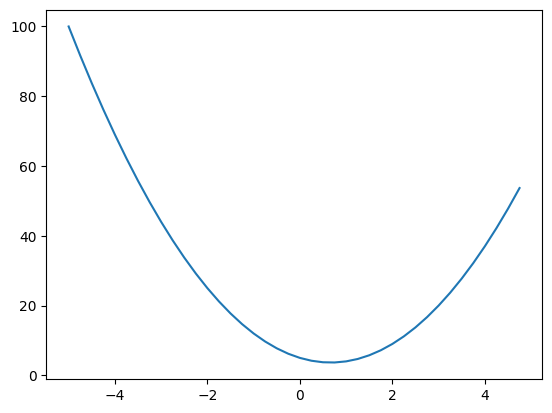

In [85]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [86]:
h = 0.000001
x = 2/3
(f(x+h) -f(x))/h

2.999378523327323e-06

In [87]:
#let's get more complex (ok karpathy)

a = 2.0
b = -3
c = 10

d = a*b+c
print(d)

4.0


In [88]:
h = 0.0001

#inputs
a = 2.0
b = -3
c = 10

d1 = a*b+c
c += h
d2 = a*b+c
print('d1,',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1, 4.0
d2 4.0001
slope 0.9999999999976694


In [148]:
class Value:
    def __init__(self,data, _children = (), _op ='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f'Value(data={self.data})'
    

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,),f'**{other}')
        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    def __rmul__(self,other): #other * self
        return self*other
    
    def __truediv__(self,other):
        return self * other **-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

        

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'

d = e + c; d.label = 'd'
f = Value(-2.0, label ='f')
L = d*f; L.label = 'L'


In [143]:
a = Value(2.0)
b = Value(4.0)



Value(data=14.7781121978613)

In [90]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{ %s |data %.4f | grad%.4f}' % (n.label,n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

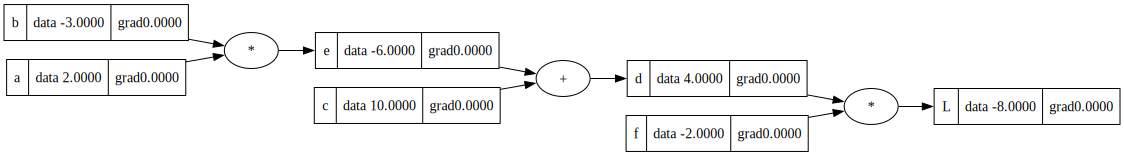

In [91]:
draw_dot(L)

In [92]:
#dd/dc? 1.0
#dd/de? 1.0

#d = c + e

#Chain rule!
#we want:
#dL/dc
#we know:
#dL/dd = -2.0
#dd/dc = 1.0

#chain rule states (dL/dd) * (dd/dc) = dL/dc

#lets apply chain rule again to get dL / da and dL / db
#we know that:
#dL/de = -2.0
#chain rule says that dL / da = (dL / de) * local gradient.
#dL / da = (dL / de) * (de/da) 

#e = a*b, 
#de/da = b
#de/db = a
#so dL/da = (dL/de) * b
#and dL/db = (dL/de) * a

In [93]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'

L.grad = 1.0
f.grad = 4.0
d.grad = -2
c.grad = -2.0 * 1.0
e.grad = -2.0 * 1.0
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a*b
d = e+c
L = d*f

L.data


-7.4352

In [94]:
def numerical_derivator():
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label ='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    b.data += h
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label ='f')
    L = d*f; L.label = 'L'
    L2 = L.data 
    
    print((L2-L1)/h)

numerical_derivator()

-4.000000000008441


### Backpropagation is just recursively going through every node of a NN and locally applying the chain rule to figure out how each node affects the final output node


#### Manual Backpropagation example 2: A neuron

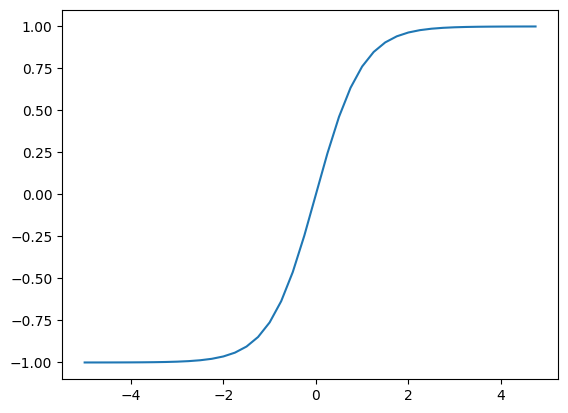

In [95]:
plt.plot( np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)))

In [139]:
#inputs x1,x2
x1 = Value(2.0, label = 'x1')

x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')

w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

#x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label='x1*w1'

x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'

o.backward()

In [97]:
#Testing out automated backpropagation 

#o.grad = 1.0
#o._backward()

In [98]:
#n._backward()

In [99]:
#b._backward()

In [100]:
#x1w1x2w2._backward()

In [101]:
#x2w2._backward()
#x1w1._backward()

In [102]:
#o.grad = 1.0
#n.grad = 1 - o.data **2 #0.5
#x1w1x2w2.grad = 0.5 #backpropagation distributes previous gradient through + operator. derivatives of both of these are 1 and chain rule thus causes us to multiply previous local derivative by 1
#b.grad = 0.5 #same as x1w1x2w2 grad definition


#Now time to do the same for x2w2 and x1w1 nerons as well, as they are also combined by an addition operator in the math expression. same logic as before
#x2w2.grad = 0.5
#x1w1.grad = 0.5
#w2.grad = x2.data * x2w2.grad
#x2.grad = w2.data * x2w2.grad

#w1.grad = x1.data * x1w1.grad
#x1.grad = w1.data * x1w1.grad

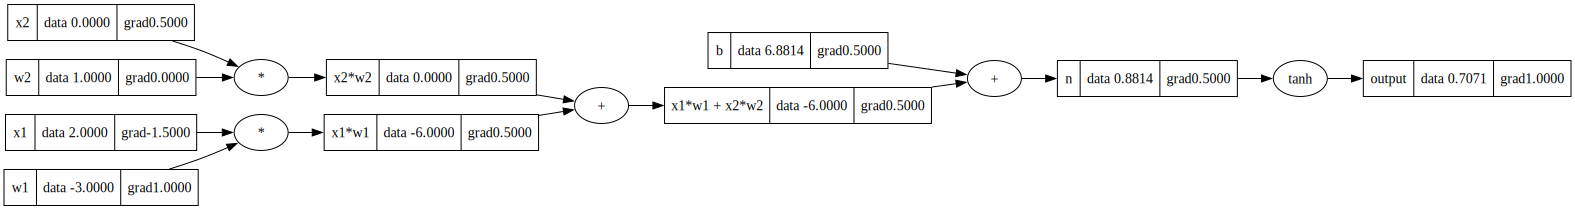

In [140]:

draw_dot(o)


In [104]:
# o = tanh(n)
# do/dn = 1-(tanh(n))**2
# do/dn = 1-o**2

In [116]:
#Implement topological sort to ensure that we can call ._backward() on all the nodes in our math expression in the correct order. In order to continuously apply the chain rule 
# we need to make sure that we can handle each nodes "gradient dependencies" Topo sort is good for this

#This code was moved inside the Value class to hide it :) 
o.backward()

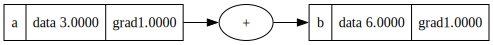

In [119]:
#We have a bug! Look: the gradient is wrong. b can be rewritten as 2a, so the gradient of b with respect to a should be 2, not 1, which is what it shows in the graph
# 
a = Value(3.0, label ='a') 
b = a+a ; b.label = 'b'

b.backward()
draw_dot(b)

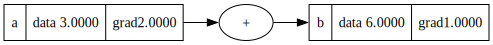

In [122]:
#This is after we have run the bug fix on the Value class to include the multivariate case of the chain rule
a = Value(3.0, label ='a') 
b = a+a ; b.label = 'b'

b.backward()
draw_dot(b)

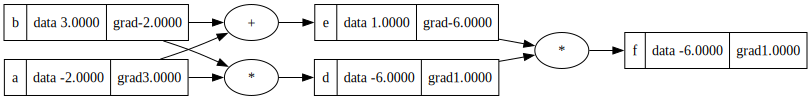

In [120]:
#This can also be seen in the slightly more complex example here: 

a = Value(-2, label = 'a')
b = Value(3.0, label = 'b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label ='f'

f.backward()
draw_dot(f)

Essentially, the issue is we keep overwriting the gradients for something because we're not using the multivariate version of the chain rule
We have to accumulate these gradients and keep adding them on top of eachother if we have 1 variable in the expression who is a child node of several other variables in the expression

This "child of many" node affects the output node through many different parent nodes that lead to the output. We add all these different ways. 

Time to go edit the Value class again

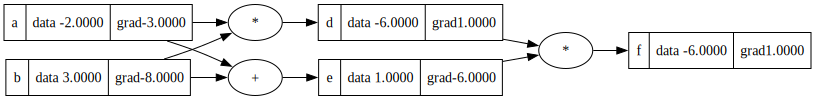

In [123]:
#This is after we have run the bug fix on the Value class to include the multivariate case of the chain rule. Correct gradients!
a = Value(-2, label = 'a')
b = Value(3.0, label = 'b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label ='f'

f.backward()
draw_dot(f)

In [132]:
#We are now atomizing the Tanh function and building it out of Value class operations. This forces us to implement more operators in our Value class since we'll need those to 
#implement tanh out of Value instances

#we are also editing the operators in the Value class so that statements like


#a = Value(2.0)

#a+1

#make sense and work

#Also implemented __rmul__ to ensure that 2*a works just as well as a x 2 

#implemented exp() in Value class, and also implemented division via a more generalised x**k operator which can just be -1 when we want division (the same thing!)

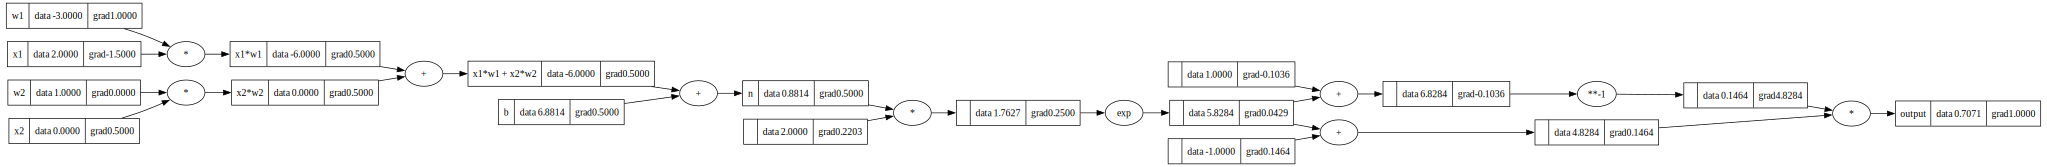

In [149]:
#Neuron simulator with our homemade Tanh :)

#inputs x1,x2
x1 = Value(2.0, label = 'x1')

x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')

w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

#x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label='x1*w1'

x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e- 1)/(e+1) 

o.label = 'output'

o.backward()

draw_dot(o)